In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from typing import Union, List
from enum import Enum
import json

from PIL import Image
import numpy as np

import torch
from torchvision import transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import pytorch_grad_cam as cam
import pytorch_grad_cam.utils as utils
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [2]:
'''
Implementation of Energy-based Pointing Game proposed in Score-CAM.
'''

import os
import torch
import pandas as pd
from PIL import Image
import torchvision.models as models

'''
bbox (list): upper left and lower right coordinates of object bounding box
saliency_map (array): explanation map, ignore the channel
'''
def energy_point_game(bbox, saliency_map):
  
  x1, y1, x2, y2 = bbox
  w, h = saliency_map.shape
  
  empty = torch.zeros((w, h))
  empty[x1:x2, y1:y2] = 1
  mask_bbox = saliency_map * empty  
  
  energy_bbox =  mask_bbox.sum()
  energy_whole = saliency_map.sum()
  
  proportion = energy_bbox / energy_whole
  
  return proportion

def filter_images(csv_file, images_folder, num_samples=None):
    eligible_images = []
    data = pd.read_csv(csv_file)
    data = data.sample(frac=1).reset_index(drop=True)  # Shuffle data for randomness upfront

    for _, row in data.iterrows():
        image_id = row["ImageId"]
        predictions = row["PredictionString"].split()

        # Parse predictions into labels and coordinates
        bboxes = []
        for i in range(0, len(predictions), 5):
            class_label = predictions[i]
            coords = list(map(int, predictions[i + 1:i + 5]))
            bboxes.append((class_label, coords))

        # Skip if there are multiple bounding boxes
        if len(bboxes) > 1:
            continue

        # Load the image to get dimensions
        image_path = f"{images_folder}/{image_id}.JPEG"
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        image = Image.open(image_path)
        img_width, img_height = image.size

        # Calculate total bounding box area
        total_bbox_area = sum(
            (x_max - x_min) * (y_max - y_min)
            for _, (x_min, y_min, x_max, y_max) in bboxes
        )
        image_area = img_width * img_height

        # Skip if the object occupies 50% or more of the image
        if total_bbox_area / image_area >= 0.5:
            continue

        # Add eligible image and bounding box to the list
        eligible_images.append(row)

        # Stop if we've collected enough samples
        if num_samples and len(eligible_images) >= num_samples:
            break

    return eligible_images


In [3]:
class CAMType(Enum):
    GRAD_CAM = cam.GradCAM
    HI_RES_CAM = cam.HiResCAM
    GRAD_CAM_ELEMENT_WISE = cam.GradCAMElementWise
    ABLATION_CAM = cam.AblationCAM
    X_GRAD_CAM = cam.XGradCAM
    GRAD_CAM_PLUS_PLUS = cam.GradCAMPlusPlus
    SCORE_CAM = cam.ScoreCAM
    LAYER_CAM = cam.LayerCAM
    EIGEN_CAM = cam.EigenCAM
    EIGEN_GRAD_CAM = cam.EigenGradCAM
    KPCA_CAM = cam.KPCA_CAM
    RANDOM_CAM = cam.RandomCAM
    FULL_GRAD = cam.FullGrad

def get_cam(cam_type: CAMType, model: torch.nn.Module, target_layers: torch.nn.Module):
    cam_class = cam_type.value
    return cam_class(model=model, target_layers=target_layers)

def visualize(grayscale: torch.Tensor, rgb_img: np.ndarray):
    visualization = show_cam_on_image(rgb_img, grayscale, use_rgb=True)
    plt.imshow(visualization)
    plt.axis('off')
    plt.show()

def draw_bb(img, bb):
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(img, cmap='gray')

    # Define the bounding box coordinates
    x1, y1, x2, y2 = bb

    # Calculate width and height
    width = x2 - x1
    height = y2 - y1

    # Create a rectangle patch
    rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='red', facecolor='none')

    # Add the rectangle to the axes
    ax.add_patch(rect)

    # Show the image with the bounding box
    plt.show()

def display_images_in_rows(rgb_img: np.ndarray, grayscale_list: List[torch.Tensor], labels: List[str]):
    """
    Displays a list of images in rows, with each row containing up to max_images_per_row images.
    
    Args:
        images (list of np.ndarray): List of images to display.
        labels (list of str): List of labels for each image.
        max_images_per_row (int): Maximum number of images per row (default is 4).
    """

    images = [rgb_img]

    for grayscale in grayscale_list:
        images.append(show_cam_on_image(rgb_img, grayscale, use_rgb=True))

    labels.insert(0, "Image")

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # Loop through the images and labels to display them
    for ax, img, label in zip(axes, images, labels):
        ax.imshow(img)  # Show the image
        ax.set_title(label)  # Set the title
        ax.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

def execute_cam(
        img_path: str,
        preprocess: transforms.Compose, model: torch.nn.Module,
        target_layers: List[torch.nn.Module],
        cam_type: CAMType,
        targets: Union[List[ClassifierOutputTarget], None] = None,
        visualization: bool = False,
        output_path: Union[str, None] = None
    ):
        # Load the image from file
        rgb_img = Image.open(img_path).convert('RGB')

        # Apply the transformations to the image and add a batch dimension
        input_tensor = preprocess(rgb_img).unsqueeze(0).cuda()  # Add batch dimension (1, 3, 224, 224)

        # Forward to get target class if not specified
        if not targets:
            with torch.no_grad():
                predicted_class = model(input_tensor).max(1)[-1]
                targets = [ClassifierOutputTarget(predicted_class)]
                print(f"Target class: {labels[str(predicted_class.item())][1]}")

        cam = get_cam(cam_type=cam_type, model=model, target_layers=target_layers)

        # Generate the CAM
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]  # For a single image

        # Overlay the CAM on the image
        if visualization:
            # Convert the PIL image to a NumPy array for visualization
            rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0  # Normalize the pixel values
            
            visualize(grayscale=grayscale_cam, rgb_img=rgb_img)

            # Optionally, you can save the resulting CAM visualization
            if output_path:
                Image.fromarray((visualization * 255).astype(np.uint8)).save(output_path)
                print(f"Saved output image to {output_path}")

        return grayscale_cam

labels = json.load(open("../pytorch_grad_cam/utils/imagenet_class_index.json"))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
csv_file = "../LOC_val_solution/LOC_val_solution.csv"  # Replace with your CSV file
images_folder = "../val_folder"  # Replace with the folder containing the images

images = filter_images(csv_file=csv_file, images_folder=images_folder, num_samples=500)

In [5]:
vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).eval().cuda()
target_layers = [vgg.features[29]]

In [10]:
total_proportion = 0

for image in images:
    img_path = f"{images_folder}/{image['ImageId']}.JPEG"

    # Open image to get original dimensions
    with Image.open(img_path) as img:
        orig_width, orig_height = img.size

    # Resize the image
    rgb_img = Image.open(img_path).convert('RGB')
    rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0

    # Adjust bounding box to resized image
    bbox = list(map(int, image["PredictionString"].split()[1:5]))
    x_min, y_min, x_max, y_max = bbox
    x_min = int(x_min * 224 / orig_width)
    y_min = int(y_min * 224 / orig_height)
    x_max = int(x_max * 224 / orig_width)
    y_max = int(y_max * 224 / orig_height)
    resized_bbox = [x_min, y_min, x_max, y_max]

    # Run CAM visualization
    score_cam = execute_cam(
        img_path=img_path,
        preprocess=transform,
        model=vgg,
        target_layers=target_layers,
        cam_type=CAMType.SCORE_CAM,
        # visualization=True
    )

    # Draw resized bounding box
    # draw_bb(img=rgb_img, bb=resized_bbox)

    # Convert score CAM to tensor
    score_cam_tensor = torch.from_numpy(score_cam)

    # Compute energy proportion
    proportion = energy_point_game(bbox=resized_bbox, saliency_map=score_cam_tensor)

    total_proportion += proportion

    print(proportion)
    print("-----------------")

print("Proportion:", total_proportion / len(images))

Target class: Kerry_blue_terrier


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.5461)
-----------------
Target class: Border_collie


100%|██████████| 32/32 [00:04<00:00,  7.13it/s]


tensor(0.6578)
-----------------
Target class: slug


100%|██████████| 32/32 [00:04<00:00,  7.15it/s]


tensor(0.4114)
-----------------
Target class: pickelhaube


100%|██████████| 32/32 [00:04<00:00,  7.15it/s]


tensor(0.0041)
-----------------
Target class: sandbar


100%|██████████| 32/32 [00:04<00:00,  7.13it/s]


tensor(0.3239)
-----------------
Target class: knot


100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


tensor(0.4360)
-----------------
Target class: llama


100%|██████████| 32/32 [00:04<00:00,  7.14it/s]


tensor(0.6424)
-----------------
Target class: Indian_cobra


100%|██████████| 32/32 [00:04<00:00,  7.14it/s]


tensor(0.5570)
-----------------
Target class: albatross


100%|██████████| 32/32 [00:04<00:00,  7.12it/s]


tensor(0.5264)
-----------------
Target class: bittern


100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


tensor(0.4243)
-----------------
Target class: home_theater


100%|██████████| 32/32 [00:04<00:00,  7.14it/s]


tensor(0.0619)
-----------------
Target class: bittern


100%|██████████| 32/32 [00:04<00:00,  7.14it/s]


tensor(0.8691)
-----------------
Target class: kite


100%|██████████| 32/32 [00:04<00:00,  7.14it/s]


tensor(0.7746)
-----------------
Target class: meat_loaf


100%|██████████| 32/32 [00:04<00:00,  7.13it/s]


tensor(0.1012)
-----------------
Target class: cornet


100%|██████████| 32/32 [00:04<00:00,  7.15it/s]


tensor(0.1824)
-----------------
Target class: anemone_fish


100%|██████████| 32/32 [00:04<00:00,  7.16it/s]


tensor(0.4875)
-----------------
Target class: trailer_truck


100%|██████████| 32/32 [00:04<00:00,  7.16it/s]


tensor(0.1145)
-----------------
Target class: bikini


100%|██████████| 32/32 [00:04<00:00,  7.16it/s]


tensor(0.7483)
-----------------
Target class: steel_drum


100%|██████████| 32/32 [00:04<00:00,  7.16it/s]


tensor(0.6126)
-----------------
Target class: English_springer


100%|██████████| 32/32 [00:04<00:00,  7.14it/s]


tensor(0.6611)
-----------------
Target class: Arabian_camel


100%|██████████| 32/32 [00:04<00:00,  7.16it/s]


tensor(0.5701)
-----------------
Target class: common_newt


100%|██████████| 32/32 [00:04<00:00,  7.14it/s]


tensor(0.5665)
-----------------
Target class: ashcan


100%|██████████| 32/32 [00:04<00:00,  7.13it/s]


tensor(0.5650)
-----------------
Target class: cricket


100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


tensor(0.6117)
-----------------
Target class: ant


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.0197)
-----------------
Target class: green_snake


100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


tensor(0.5992)
-----------------
Target class: croquet_ball


100%|██████████| 32/32 [00:04<00:00,  7.12it/s]


tensor(0.1245)
-----------------
Target class: Pekinese


100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


tensor(0.9041)
-----------------
Target class: llama


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.0914)
-----------------
Target class: diaper


100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


tensor(0.1880)
-----------------
Target class: Saluki


100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


tensor(0.6119)
-----------------
Target class: apiary


100%|██████████| 32/32 [00:04<00:00,  6.69it/s]


tensor(0.5961)
-----------------
Target class: Bouvier_des_Flandres


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.7468)
-----------------
Target class: pretzel


100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


tensor(0.8888)
-----------------
Target class: sweatshirt


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.8393)
-----------------
Target class: pirate


100%|██████████| 32/32 [00:04<00:00,  6.97it/s]


tensor(0.0014)
-----------------
Target class: sea_lion


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.2471)
-----------------
Target class: groom


100%|██████████| 32/32 [00:04<00:00,  7.12it/s]


tensor(0.0281)
-----------------
Target class: spatula


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.1419)
-----------------
Target class: chain_saw


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.5511)
-----------------
Target class: English_springer


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.1227)
-----------------
Target class: rubber_eraser


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.7200)
-----------------
Target class: washbasin


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.1581)
-----------------
Target class: banded_gecko


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.3786)
-----------------
Target class: toilet_tissue


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.7379)
-----------------
Target class: bakery


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.6114)
-----------------
Target class: Irish_terrier


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


tensor(0.7442)
-----------------
Target class: pencil_sharpener


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.9143)
-----------------
Target class: cicada


100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


tensor(0.7763)
-----------------
Target class: giant_schnauzer


100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


tensor(0.1947)
-----------------
Target class: tobacco_shop


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.5461)
-----------------
Target class: liner


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


tensor(0.2511)
-----------------
Target class: hognose_snake


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


tensor(0.5852)
-----------------
Target class: notebook


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.0059)
-----------------
Target class: water_ouzel


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.0946)
-----------------
Target class: tow_truck


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.6967)
-----------------
Target class: cabbage_butterfly


100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


tensor(0.2385)
-----------------
Target class: flamingo


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.9143)
-----------------
Target class: airliner


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


tensor(0.4746)
-----------------
Target class: goblet


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.5230)
-----------------
Target class: European_gallinule


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.5747)
-----------------
Target class: broccoli


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.1393)
-----------------
Target class: timber_wolf


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.1706)
-----------------
Target class: Gila_monster


100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


tensor(0.6305)
-----------------
Target class: redshank


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.7112)
-----------------
Target class: stove


100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


tensor(0.0490)
-----------------
Target class: bloodhound


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


tensor(0.0544)
-----------------
Target class: steel_arch_bridge


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.6647)
-----------------
Target class: panpipe


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.7378)
-----------------
Target class: sundial


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.2693)
-----------------
Target class: gas_pump


100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


tensor(0.5916)
-----------------
Target class: quail


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.4202)
-----------------
Target class: wok


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.6836)
-----------------
Target class: sea_urchin


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.9160)
-----------------
Target class: pole


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.2480)
-----------------
Target class: electric_fan


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.8179)
-----------------
Target class: digital_clock


100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


tensor(0.8662)
-----------------
Target class: pot


100%|██████████| 32/32 [00:04<00:00,  6.96it/s]


tensor(0.0327)
-----------------
Target class: balance_beam


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.0268)
-----------------
Target class: red-breasted_merganser


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.3512)
-----------------
Target class: paddlewheel


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.7129)
-----------------
Target class: groom


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.6605)
-----------------
Target class: scuba_diver


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.4697)
-----------------
Target class: wallaby


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.7132)
-----------------
Target class: airliner


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.4317)
-----------------
Target class: steam_locomotive


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.6504)
-----------------
Target class: monarch


100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


tensor(0.3278)
-----------------
Target class: white_wolf


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.1740)
-----------------
Target class: platypus


100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


tensor(0.3981)
-----------------
Target class: lotion


100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


tensor(0.1490)
-----------------
Target class: diamondback


100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


tensor(0.6808)
-----------------
Target class: three-toed_sloth


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


tensor(0.5095)
-----------------
Target class: cowboy_hat


100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


tensor(0.6353)
-----------------
Target class: Kerry_blue_terrier


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.7963)
-----------------
Target class: sleeping_bag


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.2796)
-----------------
Target class: ringlet


100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


tensor(0.7140)
-----------------
Target class: medicine_chest


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.4218)
-----------------
Target class: trolleybus


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.6134)
-----------------
Target class: plane


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.4688)
-----------------
Target class: hare


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.2697)
-----------------
Target class: goldfinch


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.2041)
-----------------
Target class: French_bulldog


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.6938)
-----------------
Target class: paddle


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.4804)
-----------------
Target class: redbone


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.7031)
-----------------
Target class: swimming_trunks


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


tensor(0.0381)
-----------------
Target class: bib


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


tensor(0.0861)
-----------------
Target class: submarine


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.6670)
-----------------
Target class: pencil_sharpener


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


tensor(0.5418)
-----------------
Target class: toaster


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.7075)
-----------------
Target class: guenon


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


tensor(0.5947)
-----------------
Target class: mobile_home


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.5263)
-----------------
Target class: platypus


100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


tensor(0.7728)
-----------------
Target class: bassoon


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.5156)
-----------------
Target class: wall_clock


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


tensor(0.3004)
-----------------
Target class: redshank


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.6591)
-----------------
Target class: can_opener


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.8506)
-----------------
Target class: squirrel_monkey


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.4041)
-----------------
Target class: bathing_cap


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.5722)
-----------------
Target class: sea_snake


100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


tensor(0.6027)
-----------------
Target class: limousine


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


tensor(0.6803)
-----------------
Target class: pomegranate


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


tensor(0.5423)
-----------------
Target class: grey_fox


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.6385)
-----------------
Target class: face_powder


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.0569)
-----------------
Target class: three-toed_sloth


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.4233)
-----------------
Target class: radio_telescope


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.7285)
-----------------
Target class: guacamole


100%|██████████| 32/32 [00:04<00:00,  6.96it/s]


tensor(0.4162)
-----------------
Target class: hourglass


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.4330)
-----------------
Target class: killer_whale


100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


tensor(0.4711)
-----------------
Target class: colobus


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.4188)
-----------------
Target class: joystick


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.9861)
-----------------
Target class: damselfly


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.9179)
-----------------
Target class: maillot_tights


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.4818)
-----------------
Target class: mashed_potato


100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


tensor(0.4380)
-----------------
Target class: electric_guitar


100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


tensor(0.6536)
-----------------
Target class: recreational_vehicle


100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


tensor(0.7120)
-----------------
Target class: macaw


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.8556)
-----------------
Target class: cucumber


100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


tensor(0.3629)
-----------------
Target class: leaf_beetle


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.6487)
-----------------
Target class: tripod


100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


tensor(0.0616)
-----------------
Target class: wood_rabbit


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.7406)
-----------------
Target class: radio


100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


tensor(0.3502)
-----------------
Target class: radio


100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


tensor(0.2388)
-----------------
Target class: tarantula


100%|██████████| 32/32 [00:04<00:00,  6.89it/s]


tensor(0.0226)
-----------------
Target class: can_opener


100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


tensor(0.3899)
-----------------
Target class: toucan


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.6227)
-----------------
Target class: dingo


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.6601)
-----------------
Target class: hartebeest


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.4687)
-----------------
Target class: ski


100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


tensor(0.1050)
-----------------
Target class: badger


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.4232)
-----------------
Target class: chain


100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


tensor(0.6092)
-----------------
Target class: great_white_shark


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.3779)
-----------------
Target class: beaver


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.7553)
-----------------
Target class: paper_towel


100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


tensor(0.5758)
-----------------
Target class: ringlet


100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


tensor(0.5966)
-----------------
Target class: balance_beam


100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


tensor(0.1353)
-----------------
Target class: racket


100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


tensor(0.0266)
-----------------
Target class: dough


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.0095)
-----------------
Target class: ping-pong_ball


100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


tensor(0.0261)
-----------------
Target class: Newfoundland


100%|██████████| 32/32 [00:04<00:00,  7.02it/s]


tensor(0.8480)
-----------------
Target class: stethoscope


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.7664)
-----------------
Target class: drake


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


tensor(0.4887)
-----------------
Target class: wok


100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


tensor(0.4426)
-----------------
Target class: Great_Dane


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.4595)
-----------------
Target class: bee_eater


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.7546)
-----------------
Target class: baboon


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


tensor(0.0007)
-----------------
Target class: hot_pot


100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


tensor(0.5537)
-----------------
Target class: racket


100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


tensor(0.2842)
-----------------
Target class: tennis_ball


100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


tensor(0.2488)
-----------------
Target class: lesser_panda


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.9369)
-----------------
Target class: knot


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.3219)
-----------------
Target class: hand_blower


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


tensor(0.2836)
-----------------
Target class: spoonbill


100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


tensor(0.1617)
-----------------
Target class: seat_belt


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.2888)
-----------------
Target class: picket_fence


100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


tensor(0.3930)
-----------------
Target class: water_snake


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.3963)
-----------------
Target class: jigsaw_puzzle


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


tensor(0.1925)
-----------------
Target class: bison


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.2222)
-----------------
Target class: tobacco_shop


100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


tensor(0.2363)
-----------------
Target class: solar_dish


100%|██████████| 32/32 [00:04<00:00,  6.98it/s]


tensor(0.6161)
-----------------
Target class: hummingbird


100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


tensor(0.5606)
-----------------
Target class: shopping_cart


100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


tensor(0.7477)
-----------------
Target class: miniature_pinscher


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.6378)
-----------------
Target class: paintbrush


100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


tensor(0.0198)
-----------------
Target class: steam_locomotive


100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


tensor(0.9034)
-----------------
Target class: terrapin


100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


tensor(0.3487)
-----------------
Target class: beaver


100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


tensor(0.9897)
-----------------
Target class: mountain_bike


100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


tensor(0.8567)
-----------------
Target class: breastplate


 53%|█████▎    | 17/32 [00:02<00:02,  7.09it/s]

: 

Executing CAM on VGG with target layer ReLU:
Target class: trombone
Executing CAM on VGG with target layer ReLU:
Target class: trombone


100%|██████████| 32/32 [00:04<00:00,  7.22it/s]


Combining GradCAM++ and ScoreCAM:


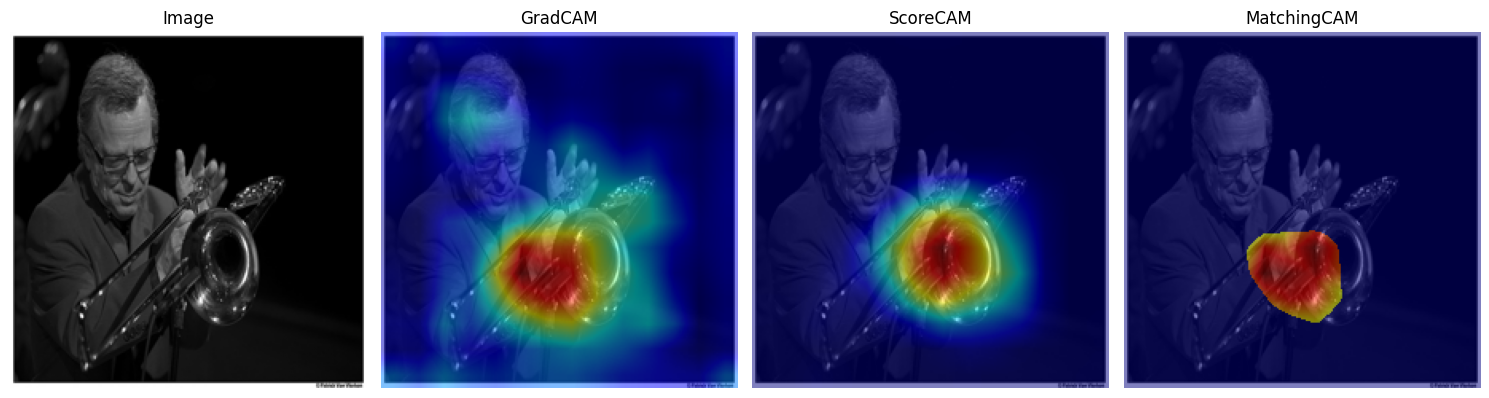

In [30]:
for image in images:
    img_path = f"{images_folder}/{image['ImageId']}.JPEG"

    grad_cam_pp = execute_cam(img_path=img_path, preprocess=transform, model=vgg, target_layers=target_layers, cam_type=CAMType.GRAD_CAM_PLUS_PLUS)

    score_cam = execute_cam(img_path=img_path, preprocess=transform, model=vgg, target_layers=target_layers, cam_type=CAMType.SCORE_CAM)

    print("Combining GradCAM++ and ScoreCAM:")
    matching_cam = utils.combine_by_matching_important_pixels(grayscales=[grad_cam_pp, score_cam], thresholds=[0.6, 0.3])

    rgb_img = Image.open(img_path).convert('RGB')
    rgb_img = np.array(rgb_img.resize((224, 224))) / 255.0
    display_images_in_rows(rgb_img=rgb_img, grayscale_list=[grad_cam_pp, score_cam, matching_cam], labels=["GradCAM", "ScoreCAM", "MatchingCAM"])

    break